In [1]:
import numpy as np
from scipy import io

###Import functions for binning data for preprocessing###
from Neural_Decoding.preprocessing_funcs import bin_spikes
from Neural_Decoding.preprocessing_funcs import bin_output

###Load Data###
folder='/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets'
data=io.loadmat(folder+'MTFEF-pa29dir4A-1600ms.mat')
spike_times=data['spike_times'] #Load spike times of all neurons
vels=data['outputs'] #Load x and y velocities
vel_times=data['vel_times'] #Load times at which velocities were recorded
vel_times=np.squeeze(vel_times)


dt=.05 #Size of time bins (in seconds)
t_start=vel_times[0] #Time to start extracting data - here the first time velocity was recorded
t_end=vel_times[-1] #Time to finish extracting data - here the last time velocity was recorded
downsample_factor=1 #Downsampling of output (to make binning go faster). 1 means no downsampling.


#When loading the Matlab cell "spike_times", Python puts it in a format with an extra unnecessary dimension
#First, we will put spike_times in a cleaner format: an array of arrays
spike_times=np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]=np.squeeze(spike_times[i])



###Preprocessing to put spikes and output in bins###

#Bin neural data using "bin_spikes" function


neural_data=bin_spikes(spike_times,dt,t_start,t_end)

#Bin output (velocity) data using "bin_output" function
vels_binned=bin_output(vels,vel_times,dt,t_start,t_end,downsample_factor)




import pickle

data_folder='/Users/liubing/Documents/data/FEF_decoding/1_FEF_MT/decoding_results/' #FOLDER YOU WANT TO SAVE THE DATA TO

with open(data_folder+'decoding_model_data_pos_1600ms_pa29.pickle','wb') as f:
    pickle.dump([neural_data,vels_binned],f)




Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from scipy import io
from scipy import stats
import pickle

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder

In [3]:
folder='/Users/liubing/Documents/data/FEF_decoding/1_FEF_MT/decoding_results/' #ENTER THE FOLDER THAT YOUR DATA IS IN
# folder='/home/jglaser/Data/DecData/' 
# folder='/Users/jig289/Dropbox/Public/Decoding_Data/'

with open(folder+'decoding_model_data_pos_1600ms_pa29.pickle','rb') as f:
    neural_data,vels_binned=pickle.load(f,encoding='latin1') #If using python 3
#     neural_data,vels_binned=pickle.load(f) #If using python 2

# #If you would prefer to load the '.h5' example file rather than the '.pickle' example file.
# data=dd.io.load(folder+'example_data_s1.h5')
# neural_data=data['neural_data']
# vels_binned=data['vels_binned']

bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=6 #How many bins of neural data after the output are used for decoding

In [4]:
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

y=vels_binned

In [5]:
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

In [6]:
num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+bins_before,np.int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set,:]

In [7]:
X_train_mean=np.nanmean(X_train,axis=0)
X_train_std=np.nanstd(X_train,axis=0)
X_train=(X_train-X_train_mean)/X_train_std
X_test=(X_test-X_train_mean)/X_train_std
X_valid=(X_valid-X_train_mean)/X_train_std

#Z-score "X_flat" inputs. 
X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
X_flat_train_std=np.nanstd(X_flat_train,axis=0)
X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

#Zero-center outputs
y_train_mean=np.mean(y_train,axis=0)
y_train=y_train-y_train_mean
y_test=y_test-y_train_mean
y_valid=y_valid-y_train_mean

In [8]:
#Declare model
model_wf=WienerFilterDecoder()

#Fit model
model_wf.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_wf=model_wf.predict(X_flat_valid)

#Get metric of fit
R2s_wf=get_R2(y_valid,y_valid_predicted_wf)
print('R2s:', R2s_wf)

R2s: [0.62333736 0.64386914]


In [30]:
import scipy.io as sio
sio.savemat('decoding_data_1600ms_wf_pa29.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_valid_predicted_wf': y_valid_predicted_wf,'R2s_wf':R2s_wf})

In [9]:
#Declare model
model_wc=WienerCascadeDecoder(degree=3)

#Fit model
model_wc.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_wc=model_wc.predict(X_flat_valid)

#Get metric of fit
R2s_wc=get_R2(y_valid,y_valid_predicted_wc)
print('R2s:', R2s_wc)

R2s: [0.62624308 0.64306022]


In [10]:
def wc_evaluate(degree):
    model_wc=WienerCascadeDecoder(degree) #Define model
    model_wc.fit(X_flat_train,y_train) #Fit model
    y_valid_predicted_wc=model_wc.predict(X_flat_valid) #Validation set predictions
    return np.mean(get_R2(y_valid,y_valid_predicted_wc)) #R2 value of validation set (mean over x and y position/velocity)

In [13]:
#Define Bayesian optimization, and set limits of hyperparameters 
#Here, we set the limit of "degree" to be [1, 6.99], so we test degrees 1,2,3,4,5,6
wcBO = BayesianOptimization(wc_evaluate, {'degree': (1, 20.99)}, verbose=0)
#Set number of initial runs (init_points) and subsequent tests (n_iter), and do the optimization
#kappa is a parameter that sets exploration vs exploitation in the algorithm
#We set kappa=10 (greater than the default) so there is more exploration when there are more hyperparameters
wcBO.maximize(init_points=5, n_iter=5, kappa=10)

In [14]:
wcBO.res

[{'target': 0.6425258764286511, 'params': {'degree': 17.45881554264842}},
 {'target': 0.6425258764286511, 'params': {'degree': 17.473164408168923}},
 {'target': 0.642602232362902, 'params': {'degree': 15.536339630374894}},
 {'target': 0.6336032499600186, 'params': {'degree': 1.4427104361927297}},
 {'target': 0.6425899733781657, 'params': {'degree': 13.448219968887441}},
 {'target': 0.64253351425576, 'params': {'degree': 20.988558640921553}},
 {'target': 0.64253351425576, 'params': {'degree': 20.987886038889698}},
 {'target': 0.64253351425576, 'params': {'degree': 20.986481121465882}},
 {'target': 0.6425399145196373, 'params': {'degree': 12.158561527801956}},
 {'target': 0.64253351425576, 'params': {'degree': 20.98963887012126}}]

In [15]:
wcBO.res[2]

{'target': 0.642602232362902, 'params': {'degree': 15.536339630374894}}

In [16]:
#Declare model
model_wc=WienerCascadeDecoder(degree=16)

#Fit model
model_wc.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_wc=model_wc.predict(X_flat_valid)

#Get metric of fit
R2s_wc=get_R2(y_valid,y_valid_predicted_wc)
print('R2s:', R2s_wc)

R2s: [0.63335123 0.65171926]


In [44]:
import scipy.io as sio
sio.savemat('decoding_data_1600ms_wc_optimized_pa29.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_valid_predicted_wc': y_valid_predicted_wc,'R2s_wc':R2s_wc, 'wcBO':wcBO})

In [12]:
#Declare model
model_xgb=XGBoostDecoder(max_depth=3,num_round=200,eta=0.3,gpu=-1) 

#Fit model
model_xgb.fit(X_flat_train, y_train)

#Get predictions
y_valid_predicted_xgb=model_xgb.predict(X_flat_valid)

#Get metric of fit
R2s_xgb=get_R2(y_valid,y_valid_predicted_xgb)
print('R2s:', R2s_xgb)

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


R2s: [0.66779588 0.6541842 ]


In [45]:
def xgb_evaluate(max_depth,num_round,eta):
    #The parameters need to be in the correct format for the decoder, so we do that below
    max_depth=int(max_depth) 
    num_round=int(num_round) 
    eta=float(eta) 
    #Define model
    model_xgb=XGBoostDecoder(max_depth=max_depth, num_round=num_round, eta=eta) 
    model_xgb.fit(X_flat_train,y_train) #Fit model
    y_valid_predicted_xgb=model_xgb.predict(X_flat_valid) #Get validation set predictions
    return np.mean(get_R2(y_valid,y_valid_predicted_xgb)) #Return mean validation set R2

In [46]:
#Do bayesian optimization, and set limits of hyperparameters
xgbBO = BayesianOptimization(xgb_evaluate, {'max_depth': (2, 6.99), 'num_round': (100,600.99), 'eta': (0.01, 0.8)},verbose=0) #Define Bayesian optimization, and set limits of hyperparameters    
#Set number of initial runs and subsequent tests, and do the optimization. Also, we set kappa=10 (greater than the default) so there is more exploration when there are more hyperparameters
xgbBO.maximize(init_points=10, n_iter=10, kappa=10)

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sli

In [47]:
xgbBO.res

[{'target': 0.660460603328515,
  'params': {'eta': 0.379110794719938,
   'max_depth': 5.052430008755403,
   'num_round': 315.5680333315837}},
 {'target': 0.6679004293279232,
  'params': {'eta': 0.35590814328346093,
   'max_depth': 5.81698221712522,
   'num_round': 297.7974269781441}},
 {'target': 0.6623114467703424,
  'params': {'eta': 0.5196495556058027,
   'max_depth': 2.669593775910279,
   'num_round': 448.87691274699574}},
 {'target': 0.6385917919462357,
  'params': {'eta': 0.43364154153058276,
   'max_depth': 6.767307440131784,
   'num_round': 371.58348442114686}},
 {'target': 0.6730935870470531,
  'params': {'eta': 0.3067448018310464,
   'max_depth': 6.448213163569953,
   'num_round': 511.2402069696315}},
 {'target': 0.6187871903759039,
  'params': {'eta': 0.7169857126105803,
   'max_depth': 4.831377082045835,
   'num_round': 101.1110078185545}},
 {'target': 0.6719355852350748,
  'params': {'eta': 0.34908842444350885,
   'max_depth': 4.491016683870578,
   'num_round': 307.6169640

In [48]:
xgbBO.res[10]

{'target': 0.6955750835008261,
 'params': {'eta': 0.234729595753257,
  'max_depth': 6.898218245472424,
  'num_round': 600.9777304099216}}

In [50]:
#Declare model
model_xgb=XGBoostDecoder(max_depth=7,num_round=600,eta=0.23,gpu=-1) 

#Fit model
model_xgb.fit(X_flat_train, y_train)

#Get predictions
y_valid_predicted_xgb=model_xgb.predict(X_flat_valid)

#Get metric of fit
R2s_xgb=get_R2(y_valid,y_valid_predicted_xgb)
print('R2s:', R2s_xgb)

R2s: [0.6912863  0.67945068]


In [51]:
import scipy.io as sio
sio.savemat('decoding_data_1600ms_xgb_optimized_pa29.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_valid_predicted_xgb': y_valid_predicted_xgb,'R2s_xgb':R2s_xgb,'xgbBO':xgbBO})

In [13]:
#The SVR works much better when the y values are normalized, so we first z-score the y values
#They have previously been zero-centered, so we will just divide by the stdev (of the training set)
y_train_std=np.nanstd(y_train,axis=0)
y_zscore_train=y_train/y_train_std
y_zscore_test=y_test/y_train_std
y_zscore_valid=y_valid/y_train_std

#Declare model
model_svr=SVRDecoder(C=5, max_iter=4000)

#Fit model
model_svr.fit(X_flat_train,y_zscore_train)

#Get predictions
y_zscore_valid_predicted_svr=model_svr.predict(X_flat_valid)

#Get metric of fit
R2s_svr=get_R2(y_zscore_valid,y_zscore_valid_predicted_svr)
print('R2s:', R2s_svr)

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=4000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


R2s: [0.74678399 0.72361339]


In [56]:
import scipy.io as sio
sio.savemat('decoding_data_1600ms_svr_.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_zscore_valid_predicted_svr': y_zscore_valid_predicted_svr,'R2s_svr':R2s_svr,'svrBO':svrBO})

In [52]:
def svr_evaluate(C,max_iter):
    #The parameters need to be in the correct format for the decoder, so we do that below
    C=int(C) 
    max_iter=int(max_iter) 
    #Define model
    model_svr=SVRDecoder(C=C, max_iter=max_iter) 
    model_svr.fit(X_flat_train,y_zscore_train) #Fit model
    y_zscore_valid_predicted_svr=model_svr.predict(X_flat_valid) #Get validation set predictions
    return np.mean(get_R2(y_zscore_valid,y_zscore_valid_predicted_svr)) #Return mean validation set R2

In [53]:
#Do bayesian optimization, and set limits of hyperparameters
svrBO = BayesianOptimization(svr_evaluate, {'C': (2, 6.99), 'max_iter': (100,600.99)},verbose=0) #Define Bayesian optimization, and set limits of hyperparameters    
#Set number of initial runs and subsequent tests, and do the optimization. Also, we set kappa=10 (greater than the default) so there is more exploration when there are more hyperparameters
svrBO.maximize(init_points=10, n_iter=10, kappa=10)

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=284).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=284).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=106).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=106).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=582).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=495).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=495).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=599).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

In [54]:
svrBO.res

[{'target': 0.5947218286163267,
  'params': {'C': 5.427198816006814, 'max_iter': 284.2647640364906}},
 {'target': 0.4752108435142605,
  'params': {'C': 2.837111513219895, 'max_iter': 106.95466918505709}},
 {'target': 0.6187365212535356,
  'params': {'C': 3.2370247515364, 'max_iter': 468.03354951900104}},
 {'target': 0.5943920573421838,
  'params': {'C': 4.505629440640794, 'max_iter': 299.1269254841039}},
 {'target': 0.5953301818094847,
  'params': {'C': 5.5907519065427955, 'max_iter': 267.61522819519786}},
 {'target': 0.6123926953506049,
  'params': {'C': 4.958283236468778, 'max_iter': 397.7416461560001}},
 {'target': 0.6026652755113804,
  'params': {'C': 2.4232636656905693, 'max_iter': 363.0762000000503}},
 {'target': 0.6207180390668606,
  'params': {'C': 4.438194020221816, 'max_iter': 428.5361946711224}},
 {'target': 0.5992547726390417,
  'params': {'C': 3.0491401619785172, 'max_iter': 380.2883766156845}},
 {'target': 0.5633416739923895,
  'params': {'C': 2.0501270863503303, 'max_ite

In [55]:
svrBO.res[18]

{'target': 0.6364065440020894,
 'params': {'C': 2.0026805746055207, 'max_iter': 599.8977551952376}}

In [15]:
#Declare model
model_dnn=DenseNNDecoder(units=400,dropout=0.25,num_epochs=10)

#Fit model
model_dnn.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)

#Get metric of fit
R2s_dnn=get_R2(y_valid,y_valid_predicted_dnn)
print('R2s:', R2s_dnn)

R2s: [0.78923564 0.77353702]


In [16]:
import scipy.io as sio
sio.savemat('decoding_data_1600ms_dnn_optimized_pa29.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_valid_predicted_dnn': y_valid_predicted_dnn,'R2s_dnn':R2s_dnn, 'dnnBO':dnnBO})

In [8]:
def dnn_evaluate(num_units,frac_dropout,n_epochs):
    #The parameters need to be in the correct format for the decoder, so we do that below
    num_units=int(num_units)
    frac_dropout=float(frac_dropout)
    n_epochs=int(n_epochs)
    #Declare and fit decoder
    model_dnn=DenseNNDecoder(units=[num_units,num_units],dropout=frac_dropout,num_epochs=n_epochs)
    model_dnn.fit(X_flat_train,y_train)
    #Make predictions and get R2 values on validation set
    y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)
    return np.mean(get_R2(y_valid,y_valid_predicted_dnn))

In [11]:
#Do bayesian optimization, and set limits of hyperparameters
dnnBO = BayesianOptimization(dnn_evaluate, {'num_units': (50, 700.99), 'frac_dropout': (0,.5), 'n_epochs': (2,15.99)},verbose=0)

#Set number of initial runs (init_points) and subsequent tests (n_iter), and do the optimization
#kappa is a parameter that sets exploration vs exploitation in the algorithm - 10 seems to work pretty welldnnBO = BayesianOptimization(dnn_evaluate, {'num_units': (50, 500), 'frac_dropout': (0.,.5), 'n_epochs': (2,15)})
dnnBO.maximize(init_points=10, n_iter=10, kappa=10)

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:391: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_flat_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:391: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_flat_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:391: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_flat_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:391: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_flat_train,y_train,nb_epoch=self.num_epochs,verbo

In [12]:
dnnBO.res

[{'target': 0.8437916058442085,
  'params': {'frac_dropout': 0.10152323987572243,
   'n_epochs': 3.519978153860275,
   'num_units': 318.2244863922437}},
 {'target': 0.8320179119867661,
  'params': {'frac_dropout': 0.3494577392676171,
   'n_epochs': 12.007723609671633,
   'num_units': 323.2700214240745}},
 {'target': 0.8526535852865568,
  'params': {'frac_dropout': 0.06685519035777349,
   'n_epochs': 14.75177705398811,
   'num_units': 254.26112769391125}},
 {'target': 0.8154499853455904,
  'params': {'frac_dropout': 0.3890438557523437,
   'n_epochs': 4.453225334927227,
   'num_units': 366.9376108681472}},
 {'target': 0.8440442157997549,
  'params': {'frac_dropout': 0.03424419366339354,
   'n_epochs': 2.6142097451839486,
   'num_units': 554.7474533575148}},
 {'target': 0.8174331895328573,
  'params': {'frac_dropout': 0.41186557286958303,
   'n_epochs': 9.378863514481317,
   'num_units': 239.57618981951637}},
 {'target': 0.8589480312708299,
  'params': {'frac_dropout': 0.04728597616231200

In [13]:
dnnBO.res[6]

{'target': 0.8589480312708299,
 'params': {'frac_dropout': 0.047285976162312005,
  'n_epochs': 9.34862110380632,
  'num_units': 538.6333142975911}}

In [14]:
#Declare model
model_dnn=DenseNNDecoder(units=539,dropout=0.05,num_epochs=9)

#Fit model
model_dnn.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)

#Get metric of fit
R2s_dnn=get_R2(y_valid,y_valid_predicted_dnn)
print('R2s:', R2s_dnn)

R2s: [0.78225958 0.76259906]


In [15]:
#Declare model
model_rnn=SimpleRNNDecoder(units=400,dropout=0,num_epochs=5)

#Fit model
model_rnn.fit(X_train,y_train)

#Get predictions
y_valid_predicted_rnn=model_rnn.predict(X_valid)

#Get metric of fit
R2s_rnn=get_R2(y_valid,y_valid_predicted_rnn)
print('R2s:', R2s_rnn)

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:463: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(400, input_shape=(13, 69), activation="relu", dropout=0, recurrent_dropout=0)`
  model.add(SimpleRNN(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout,activation='relu')) #Within recurrent layer, include dropout
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:471: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model


R2s: [0.85131258 0.81510934]


In [17]:
def rnn_evaluate(num_units,frac_dropout,n_epochs):
    #The parameters need to be in the correct format for the decoder, so we do that below
    num_units=int(num_units)
    frac_dropout=float(frac_dropout)
    n_epochs=int(n_epochs)
    #Declare and fit decoder
    model_rnn=SimpleRNNDecoder(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
    model_rnn.fit(X_train,y_train)
    #Make predictions and get R2 values on validation set
    y_valid_predicted_rnn=model_rnn.predict(X_valid)
    return np.mean(get_R2(y_valid,y_valid_predicted_rnn))

In [18]:
#Do bayesian optimization, and set limits of hyperparameters
rnnBO = BayesianOptimization(rnn_evaluate, {'num_units': (50, 800.99), 'frac_dropout': (0,.5), 'n_epochs': (2,15.99)},verbose=0)

#Set number of initial runs (init_points) and subsequent tests (n_iter), and do the optimization
#kappa is a parameter that sets exploration vs exploitation in the algorithm - 10 seems to work pretty welldnnBO = BayesianOptimization(dnn_evaluate, {'num_units': (50, 500), 'frac_dropout': (0.,.5), 'n_epochs': (2,15)})
rnnBO.maximize(init_points=10, n_iter=10, kappa=10)

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:463: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(785, input_shape=(13, 69), activation="relu", dropout=0.28075249..., recurrent_dropout=0.28075249...)`
  model.add(SimpleRNN(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout,activation='relu')) #Within recurrent layer, include dropout
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:471: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:463: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(64, input_shape=(13, 69), activation="relu", dropout=0.01958727..., recurrent_dropout=0.01958727...)`
  model.add(SimpleRNN(self.u

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:463: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(545, input_shape=(13, 69), activation="relu", dropout=0.5, recurrent_dropout=0.5)`
  model.add(SimpleRNN(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout,activation='relu')) #Within recurrent layer, include dropout
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:471: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:463: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(134, input_shape=(13, 69), activation="relu", dropout=0.5, recurrent_dropout=0.5)`
  model.add(SimpleRNN(self.units,input_shape=(X_train.shape[1],X_tr

In [19]:
rnnBO.res

[{'target': 0.7003666582685123,
  'params': {'frac_dropout': 0.28075249926385837,
   'n_epochs': 11.061102042250328,
   'num_units': 785.4166428223125}},
 {'target': 0.7892899146817152,
  'params': {'frac_dropout': 0.019587275934484616,
   'n_epochs': 2.329668302426074,
   'num_units': 64.36433301780305}},
 {'target': 0.8124801675118982,
  'params': {'frac_dropout': 0.12027696131935461,
   'n_epochs': 4.568010301396711,
   'num_units': 690.6664362930317}},
 {'target': 0.7894749009279509,
  'params': {'frac_dropout': 0.14483450136383053,
   'n_epochs': 14.58470703512448,
   'num_units': 697.9696189107757}},
 {'target': 0.8287558612415026,
  'params': {'frac_dropout': 0.023814420555736016,
   'n_epochs': 7.588929370573311,
   'num_units': 79.40460983729956}},
 {'target': 0.8085074340600193,
  'params': {'frac_dropout': 0.13840369098283006,
   'n_epochs': 4.28498248580034,
   'num_units': 594.6178902187797}},
 {'target': 0.7396081895297898,
  'params': {'frac_dropout': 0.24358177076162724

In [20]:
rnnBO.res[7]

{'target': 0.8422324481806962,
 'params': {'frac_dropout': 0.08176049470182883,
  'n_epochs': 4.1253729629806575,
  'num_units': 352.2846753881371}}

In [21]:
#Declare model
model_rnn=SimpleRNNDecoder(units=352,dropout=0.08,num_epochs=4)

#Fit model
model_rnn.fit(X_train,y_train)

#Get predictions
y_valid_predicted_rnn=model_rnn.predict(X_valid)

#Get metric of fit
R2s_rnn=get_R2(y_valid,y_valid_predicted_rnn)
print('R2s:', R2s_rnn)

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:463: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(352, input_shape=(13, 69), activation="relu", dropout=0.08, recurrent_dropout=0.08)`
  model.add(SimpleRNN(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout,activation='relu')) #Within recurrent layer, include dropout


R2s: [0.84273497 0.8418667 ]


In [22]:
import scipy.io as sio
sio.savemat('decoding_data_1600ms_rnn_optimized_pa29.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_valid_predicted_rnn': y_valid_predicted_rnn,'R2s_rnn':R2s_rnn,'rnnBO':rnnBO})

In [16]:
#Declare model
model_gru=GRUDecoder(units=400,dropout=0,num_epochs=5)

#Fit model
model_gru.fit(X_train,y_train)

#Get predictions
y_valid_predicted_gru=model_gru.predict(X_valid)

#Get metric of fit
R2s_gru=get_R2(y_valid,y_valid_predicted_gru)
print('R2s:', R2s_gru)

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:542: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(400, input_shape=(13, 69), dropout=0, recurrent_dropout=0)`
  model.add(GRU(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:550: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model


R2s: [0.8478676  0.84248641]


In [17]:
#Declare model
model_lstm=LSTMDecoder(units=400,dropout=0,num_epochs=5)

#Fit model
model_lstm.fit(X_train,y_train)

#Get predictions
y_valid_predicted_lstm=model_lstm.predict(X_valid)

#Get metric of fit
R2s_lstm=get_R2(y_valid,y_valid_predicted_lstm)
print('R2s:', R2s_lstm)

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:621: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(400, input_shape=(13, 69), dropout=0, recurrent_dropout=0)`
  model.add(LSTM(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:629: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model


R2s: [0.86214254 0.85889675]


In [23]:
def gru_evaluate(num_units,frac_dropout,n_epochs):
    #The parameters need to be in the correct format for the decoder, so we do that below
    num_units=int(num_units)
    frac_dropout=float(frac_dropout)
    n_epochs=int(n_epochs)
    #Declare and fit decoder
    model_gru=GRUDecoder(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
    model_gru.fit(X_train,y_train)
    #Make predictions and get R2 values on validation set
    y_valid_predicted_gru=model_gru.predict(X_valid)
    return np.mean(get_R2(y_valid,y_valid_predicted_gru))

In [24]:
#Do bayesian optimization, and set limits of hyperparameters
gruBO = BayesianOptimization(gru_evaluate, {'num_units': (50, 700.99), 'frac_dropout': (0,.5), 'n_epochs': (2,15.99)},verbose=0)

#Set number of initial runs (init_points) and subsequent tests (n_iter), and do the optimization
#kappa is a parameter that sets exploration vs exploitation in the algorithm - 10 seems to work pretty welldnnBO = BayesianOptimization(dnn_evaluate, {'num_units': (50, 500), 'frac_dropout': (0.,.5), 'n_epochs': (2,15)})
gruBO.maximize(init_points=10, n_iter=10, kappa=10)

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:542: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(317, input_shape=(13, 69), dropout=0.33041075..., recurrent_dropout=0.33041075...)`
  model.add(GRU(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:550: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:542: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(466, input_shape=(13, 69), dropout=0.24156880..., recurrent_dropout=0.24156880...)`
  model.add(GRU(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:550: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:542: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(160, input_shape=(13, 69), dropout=0.5, recurrent_dropout=0.5)`
  model.add(GRU(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:550: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:542: UserWarning: Update your 

In [25]:
gruBO.res

[{'target': 0.3303177636112737,
  'params': {'frac_dropout': 0.3304107553327158,
   'n_epochs': 5.201696864482901,
   'num_units': 317.5121469502883}},
 {'target': 0.4223927828343629,
  'params': {'frac_dropout': 0.24156880878488596,
   'n_epochs': 10.417796381762482,
   'num_units': 466.58482087420043}},
 {'target': 0.8241694833695548,
  'params': {'frac_dropout': 0.014193160615914413,
   'n_epochs': 8.21103494247178,
   'num_units': 93.83228616467787}},
 {'target': 0.15088566848451457,
  'params': {'frac_dropout': 0.4118128643567873,
   'n_epochs': 12.038692131884549,
   'num_units': 461.9889923432192}},
 {'target': 0.6336898449462939,
  'params': {'frac_dropout': 0.16416303930947468,
   'n_epochs': 7.9063921061590205,
   'num_units': 581.0335432991963}},
 {'target': 0.23045877718970237,
  'params': {'frac_dropout': 0.37204977601261247,
   'n_epochs': 13.356973652744983,
   'num_units': 87.7137389921204}},
 {'target': 0.06013408492848321,
  'params': {'frac_dropout': 0.40428038707397

In [26]:
gruBO.res[15]

{'target': 0.8553840512899742,
 'params': {'frac_dropout': 0.0,
  'n_epochs': 15.99,
  'num_units': 507.37578505776565}}

In [29]:
#Declare model
model_gru=GRUDecoder(units=507,dropout=0,num_epochs=16)

#Fit model
model_gru.fit(X_train,y_train)

#Get predictions
y_valid_predicted_gru=model_gru.predict(X_valid)

#Get metric of fit
R2s_gru=get_R2(y_valid,y_valid_predicted_gru)
print('R2s:', R2s_gru)

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:542: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(507, input_shape=(13, 69), dropout=0, recurrent_dropout=0)`
  model.add(GRU(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout


R2s: [0.85544375 0.84540422]


In [30]:
import scipy.io as sio
sio.savemat('decoding_data_1600ms_gru_optimized_pa29.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_valid_predicted_gru': y_valid_predicted_gru,'R2s_gru':R2s_gru,'gruBO':gruBO})

In [12]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
import time
# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder

#Import hyperparameter optimization packages
#If either are not installed, give a warning
try:
    from bayes_opt import BayesianOptimization
except ImportError:
    print("\nWARNING: BayesianOptimization package is not installed. You will be unable to use section 4.")
    pass

try:
    from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
except ImportError:
    print("\nWARNING: hyperopt package is not installed. You will be unable to use section 5.")
    pass

In [21]:
def lstm_evaluate(num_units,frac_dropout,n_epochs):
    #The parameters need to be in the correct format for the decoder, so we do that below
    num_units=int(num_units)
    frac_dropout=float(frac_dropout)
    n_epochs=int(n_epochs)
    #Declare and fit decoder
    model_lstm=LSTMDecoder(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)
    model_lstm.fit(X_train,y_train)
    #Make predictions and get R2 values on validation set
    y_valid_predicted_lstm=model_lstm.predict(X_valid)
    return np.mean(get_R2(y_valid,y_valid_predicted_lstm))

In [22]:
#Do bayesian optimization, and set limits of hyperparameters
lstmBO = BayesianOptimization(lstm_evaluate, {'num_units': (50, 700.99), 'frac_dropout': (0,.5), 'n_epochs': (2,15.99)},verbose=0)

#Set number of initial runs (init_points) and subsequent tests (n_iter), and do the optimization
#kappa is a parameter that sets exploration vs exploitation in the algorithm - 10 seems to work pretty welldnnBO = BayesianOptimization(dnn_evaluate, {'num_units': (50, 500), 'frac_dropout': (0.,.5), 'n_epochs': (2,15)})
lstmBO.maximize(init_points=10, n_iter=10, kappa=10)

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:621: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(456, input_shape=(13, 69), dropout=0.14293153..., recurrent_dropout=0.14293153...)`
  model.add(LSTM(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:621: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(188, input_shape=(13, 69), dropout=0.08236208..., recurrent_dropout=0.08236208...)`
  model.add(LSTM(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:621: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(451, input_shape=(13, 69), dropout=0.262889

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:629: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:621: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(652, input_shape=(13, 69), dropout=0.18638727..., recurrent_dropout=0.18638727...)`
  model.add(LSTM(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:629: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model
/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:621: Us

In [23]:
lstmBO.res

[{'target': 0.8615597385839979,
  'params': {'frac_dropout': 0.1429315373220047,
   'n_epochs': 5.543438396960798,
   'num_units': 456.2113080751765}},
 {'target': 0.8564093930888901,
  'params': {'frac_dropout': 0.08236208414370538,
   'n_epochs': 3.166460328644348,
   'num_units': 188.2807144437569}},
 {'target': 0.8761270403579238,
  'params': {'frac_dropout': 0.262889742904417,
   'n_epochs': 11.972300895457414,
   'num_units': 451.16614926513245}},
 {'target': 0.8498630268898533,
  'params': {'frac_dropout': 0.4297633803239204,
   'n_epochs': 9.474176497051081,
   'num_units': 162.71458646929867}},
 {'target': 0.8453809019465925,
  'params': {'frac_dropout': 0.1794425531551999,
   'n_epochs': 8.339075323600103,
   'num_units': 133.39115728472672}},
 {'target': 0.8499471000474301,
  'params': {'frac_dropout': 0.22996736318639588,
   'n_epochs': 2.6317766996182215,
   'num_units': 197.13554223556858}},
 {'target': 0.8290660090434514,
  'params': {'frac_dropout': 0.4435126542841186,


In [24]:
len(lstmBO.res)

20

In [25]:
lstmBO.res[19]

{'target': 0.8786430998183461,
 'params': {'frac_dropout': 0.2688007662853053,
  'n_epochs': 11.26475159526162,
  'num_units': 446.9557800687452}}

In [26]:
#Declare model
model_lstm=LSTMDecoder(units=447,dropout=0.269,num_epochs=11)

#Fit model
model_lstm.fit(X_train,y_train)

#Get predictions
y_valid_predicted_lstm=model_lstm.predict(X_valid)

#Get metric of fit
R2s_lstm=get_R2(y_valid,y_valid_predicted_lstm)
print('R2s:', R2s_lstm)

/Users/liubing/opt/anaconda3/lib/python3.7/site-packages/Neural_Decoding/decoders.py:621: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(447, input_shape=(13, 69), dropout=0.269, recurrent_dropout=0.269)`
  model.add(LSTM(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout


R2s: [0.86792489 0.87065952]


In [27]:
import scipy.io as sio
sio.savemat('decoding_data_1600ms_lstm_optimized_pa29.mat',{'y_valid': y_valid,'y_train_mean': y_train_mean, 'y_valid_predicted_lstm': y_valid_predicted_lstm, 'R2s_lstm':R2s_lstm,'lstmBO':lstmBO})

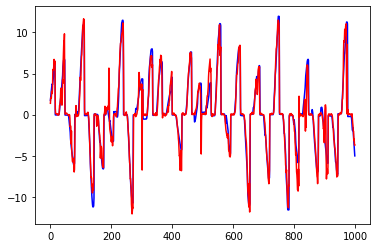

In [29]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_lstm=plt.figure()
plt.plot(y_valid[1400:2400,0]+y_train_mean[0],'b')
plt.plot(y_valid_predicted_lstm[1400:2400,0]+y_train_mean[0],'r')

#Save figure
# fig_x_wf.savefig('x_velocity_decoding.eps')